In [1]:
from utils.file_utils import merge_csv, read_csv
from utils.calc_distance import add_nearest_mrt
from utils.geocode import geocode
from preprocessing.clean import clean_data
from preprocessing.encode import encode_data
from models.validate import prepare_split
from models.graph import plot_prediction, plot_residuals
from models.knn import get_knn, test_k_values, test_knn
from models.linear_regression import test_alpha_value,test_linear,test_lasso,test_ridge
from models.regression_tree import test_tree_depth, test_rt
from models.random_forest import test_rf
from models.comparison import run_model_comparison, plot_model_comparison,summarize_best_models
import numpy as np
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import mplcursors

In [2]:
# Prepare data set
data = read_csv('output/encoded_data.csv') 
train_X, test_X, train_y, test_y = prepare_split(data)

# Model Optimization



## Linear Regression


First, we tried multiple values of alpha to determine the most optimal value of alpha for ridge or lasso regularization for this data set.

In [7]:
import warnings
warnings.simplefilter('ignore')
test_alpha_value(train_X, train_y)

Best alpha for Lasso: 0.5
Best alpha for Ridge: 0.5


Using this optimal alpha value of 0.5, we tested baseline linear regression against regression with regularization, testing against the metrics of MAE and Cross Validation R2 scoring.

In [9]:
y_pred_linear = test_linear(train_X, test_X, train_y, test_y)

RMSE: 74034.57930
MAE: 58589.04465
R2: 0.80315
Cross-validation R2 scores: [0.80782956 0.80570993 0.808826   0.805846   0.80610999]
Mean CV R2: 0.80686


In [4]:
y_pred_ridge = test_ridge(train_X, test_X, train_y, test_y, alpha = 0.5)

Ridge RMSE: 74034.22982
Ridge MAE: 58589.47442
Ridge R2: 0.80315
Cross-validation R2 scores: [0.80781369 0.80570754 0.80882146 0.80583239 0.80610404]
Mean CV R2: 0.80686


In [ ]:
y_pred_lasso = test_lasso(train_X, test_X, train_y, test_y, alpha = 1)

Lasso RMSE: 74037.13954
Lasso MAE: 58589.71935
Lasso R2: 0.80314
Cross-validation R2 scores: [0.80781711 0.80570666 0.80881871 0.80583504 0.8061039 ]
Mean CV R2: 0.80686


We concluded that linear regression is slightly more optimal than the regularization methods. This is supported by our initial EDA which showed that all features contributed equally to the prediction and overfitting is not necessarily an issue for this data. Therefore, we chose to utilize the simpler an dmore interpretable model of base linear regression.

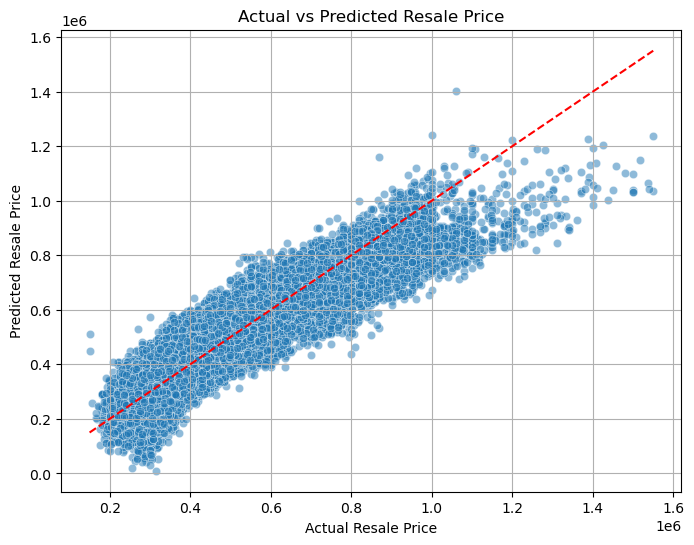

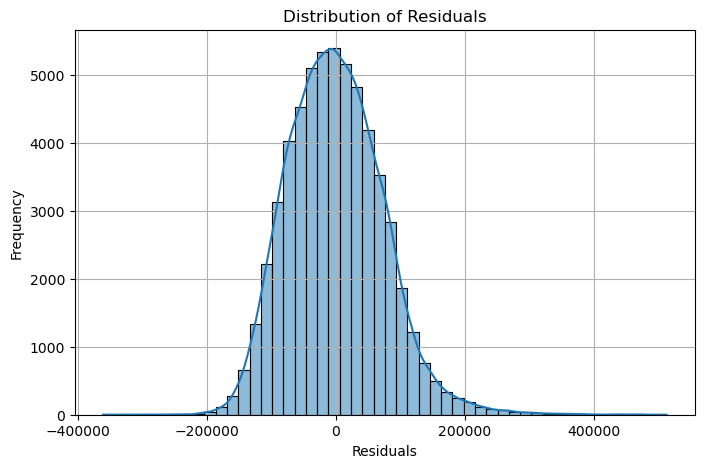

In [10]:
plot_prediction(test_y, y_pred_linear)
plot_residuals(test_y, y_pred_linear)

From the plots, we conclude that:

**Prediction Plot**
- Relatively tight clustering around the diagonal line
- Strong linear trend
- Big spike in variance for the higher-priced resale flats
    - Possibility of non-linear relationship between features and resale price for higher values, or outliers

**Residuals**
- Centered at zero -> No consistent bias
- Symmetrical and bell-shaped -> Normally distributed
- Lack of skew -> Extreme errors are rare

## K Nearest Neighbours

First, we attempt to find the most optimal k value for the nearest neighbour algorithim by plotting Cross Validation Mean R2 against k.

In [3]:
# Implementing k Nearest Neighbour Algorithm
k_lim = len(train_X)**0.5 #finding max k value for kNN
#print(k_lim)

k_values = [i for i in range(1,round(k_lim+1))]

rsq_values = []
general_k_values = []

for i in range(0,len(k_values), 20):
    knn_reg = get_knn(k_values[i])
    rsq_value = cross_val_score(knn_reg, train_X, train_y, cv = 5, scoring = "r2")
    rsq_values.append(np.mean(rsq_value))
    general_k_values.append(k_values[i])
    print(f'{k_values[i]} nearest neighbour: R^2 value: {np.mean(rsq_value)}')

1 nearest neighbour: R^2 value: 0.9073479954469199
21 nearest neighbour: R^2 value: 0.9263388599943262
41 nearest neighbour: R^2 value: 0.9132356462240839
61 nearest neighbour: R^2 value: 0.9035112978188403
81 nearest neighbour: R^2 value: 0.8960652692600162
101 nearest neighbour: R^2 value: 0.8898348637959597
121 nearest neighbour: R^2 value: 0.8843895392056949
141 nearest neighbour: R^2 value: 0.8795873078224785
161 nearest neighbour: R^2 value: 0.8752700667543536
181 nearest neighbour: R^2 value: 0.8713375940061301
201 nearest neighbour: R^2 value: 0.8677484452839475
221 nearest neighbour: R^2 value: 0.8643901380522576
241 nearest neighbour: R^2 value: 0.8612715607796659
261 nearest neighbour: R^2 value: 0.8583591279480791
281 nearest neighbour: R^2 value: 0.8556448330674401
301 nearest neighbour: R^2 value: 0.853088270186736
321 nearest neighbour: R^2 value: 0.8506780910702924
341 nearest neighbour: R^2 value: 0.8484090712903157
361 nearest neighbour: R^2 value: 0.8462457785210941


In [4]:
zoomed_rsq_values = []
zoomed_k_values = list(range(1, 42))

for i in zoomed_k_values:
    knn_reg = get_knn(i)
    rsq_value = cross_val_score(knn_reg, train_X, train_y, cv = 5, scoring = "r2")
    zoomed_rsq_values.append(np.mean(rsq_value))
    print(f'{i} nearest neighbour: R^2 value: {np.mean(rsq_value)}')

1 nearest neighbour: R^2 value: 0.9073479954469199
2 nearest neighbour: R^2 value: 0.9289484825055496
3 nearest neighbour: R^2 value: 0.9348389134908086
4 nearest neighbour: R^2 value: 0.9369036779829285
5 nearest neighbour: R^2 value: 0.9375720100690856
6 nearest neighbour: R^2 value: 0.9376671175902072
7 nearest neighbour: R^2 value: 0.93735301186812
8 nearest neighbour: R^2 value: 0.9367726286824984
9 nearest neighbour: R^2 value: 0.9361023481444125
10 nearest neighbour: R^2 value: 0.935442225541005
11 nearest neighbour: R^2 value: 0.934618331618897
12 nearest neighbour: R^2 value: 0.9337119770061937
13 nearest neighbour: R^2 value: 0.9328487083696902
14 nearest neighbour: R^2 value: 0.9319626589980373
15 nearest neighbour: R^2 value: 0.9311617773245965
16 nearest neighbour: R^2 value: 0.930378243548328
17 nearest neighbour: R^2 value: 0.9295409262743523
18 nearest neighbour: R^2 value: 0.9288182712849935
19 nearest neighbour: R^2 value: 0.9280096726361391
20 nearest neighbour: R^2 

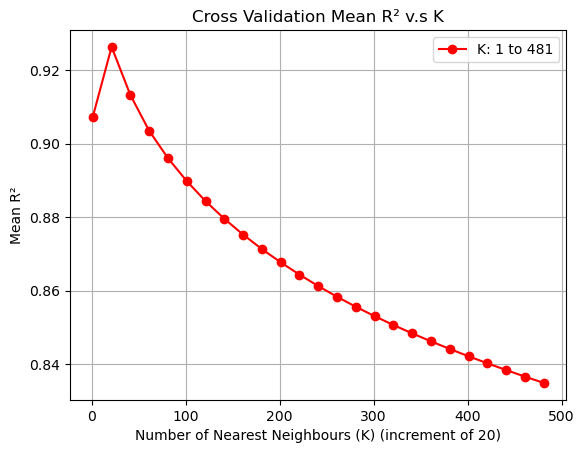

In [7]:
# Finding best k value
general_k_values = []
for i in range(0,len(k_values), 20):
    general_k_values.append(k_values[i])


# plotting R^2 values against k_values
plt.plot(general_k_values, rsq_values, color = "red", marker = "o", label = "K: 1 to 481")
plt.title("Cross Validation Mean R² v.s K")
plt.grid(True)
plt.xlabel("Number of Nearest Neighbours (K) (increment of 20)")
plt.ylabel("Mean R²")
plt.legend()
plt.show()

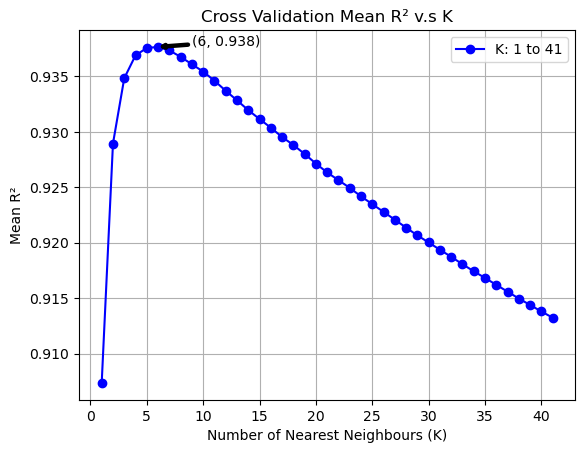

In [11]:
best_rsq_index = np.argmax(zoomed_rsq_values)
best_rsq = zoomed_rsq_values[best_rsq_index]
best_k = k_values[best_rsq_index]
zoomed_k_values = list(range(1,42))
# zoom into maximum region
plt.plot(zoomed_k_values, zoomed_rsq_values, color = "blue", marker = "o", label = "K: 1 to 41")
#plt.text(k_values[2], zoomed_rsq_values[2], f'({k_values[2]}, {round(zoomed_rsq_values[2],3)})', fontsize=12, ha='left', va='bottom')
plt.annotate(f'({best_k}, {round(best_rsq,3)})',
             xy=(best_k, best_rsq), 
             xytext=(best_k+3, best_rsq+0.0001),  # where the label appears
             arrowprops=dict(arrowstyle='->', facecolor='black', shrinkA = 0.8, shrinkB=0.005, lw = 3.2, mutation_scale = 5),
             fontsize=10)
plt.grid(True)
mplcursors.cursor(hover=True)
plt.title("Cross Validation Mean R² v.s K")
plt.xlabel("Number of Nearest Neighbours (K)")
plt.ylabel("Mean R²")
plt.legend()
plt.show()

Based on the earlier analysis, using 5-fold cross validation, R^2 value of the kNN models is maximised with k = 6 nearest neighbours with a mean R^2 value of 0.938

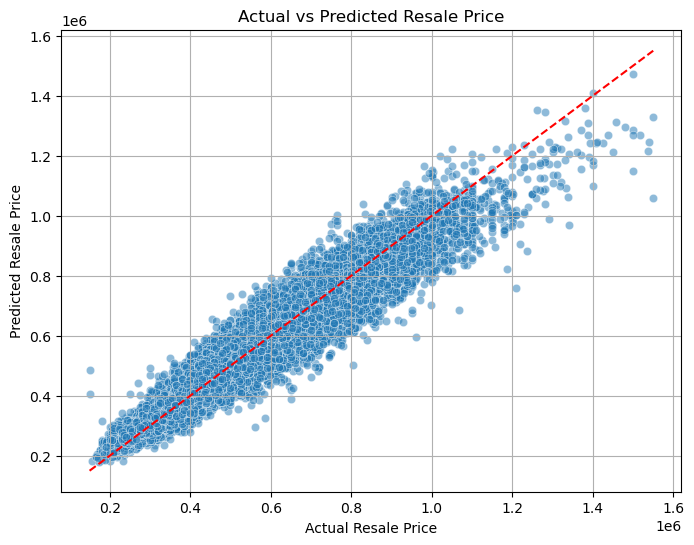

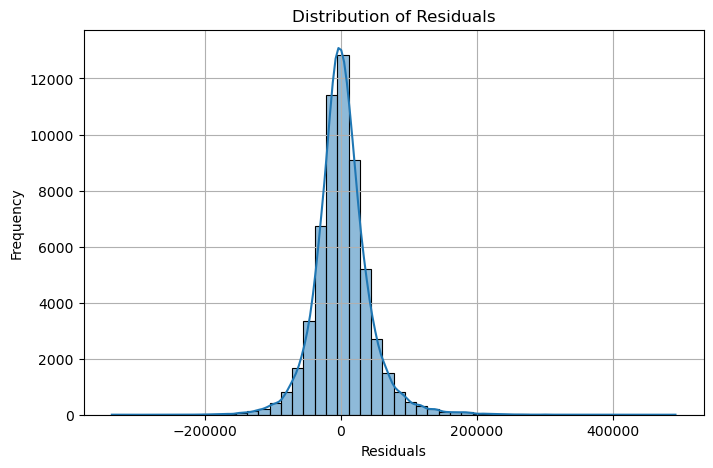

In [12]:
y_pred_knn = test_knn(train_X, test_X, train_y, n=6)
plot_prediction(test_y, y_pred_knn)
plot_residuals(test_y, y_pred_knn)

## Regression Tree


Depth 3: Mean R² = 0.5074258786788123
Depth 4: Mean R² = 0.6361387855828695
Depth 5: Mean R² = 0.7130078098860599
Depth 6: Mean R² = 0.7600644614747868
Depth 7: Mean R² = 0.7980646652202669
Depth 8: Mean R² = 0.8291074031553342
Depth 9: Mean R² = 0.8587692112653901
Depth 10: Mean R² = 0.879567798978315
Depth 11: Mean R² = 0.8977175840398637
Depth 12: Mean R² = 0.9116361065511235
Depth 13: Mean R² = 0.9225723007023194
Depth 14: Mean R² = 0.9313823685638276
Depth 15: Mean R² = 0.9371793491182366
Depth 16: Mean R² = 0.9412733045239371
Depth 17: Mean R² = 0.9439606994697037
Depth 18: Mean R² = 0.9458243515519378
Depth 19: Mean R² = 0.9465574921923643
Depth 20: Mean R² = 0.9466203565163418


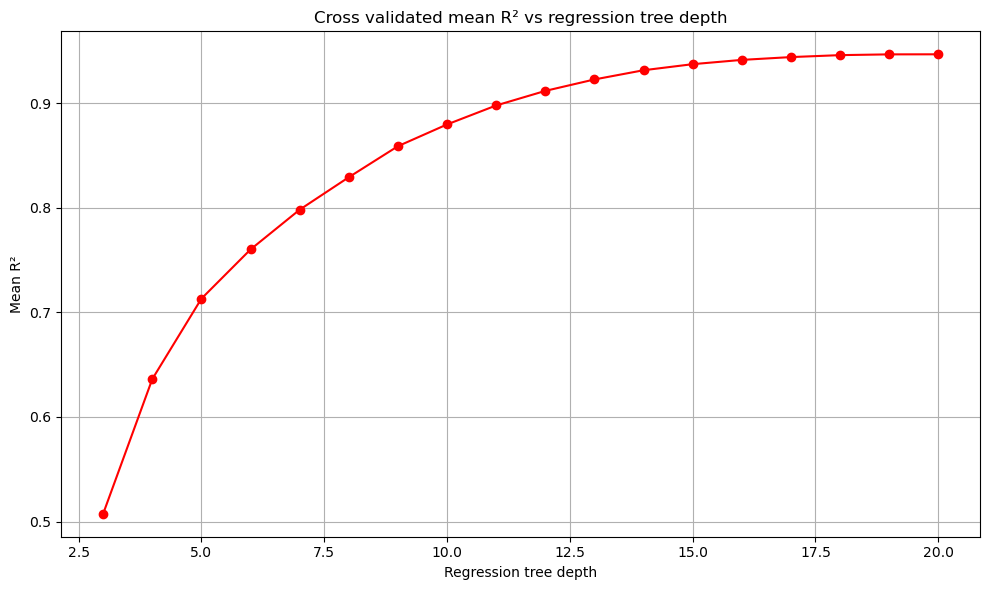

In [15]:
test_tree_depth(train_X, train_y)

We decided to choose a tree depth of 16 through 5-fold validation as not only does the mean R² values begin to plaeaeu, 
with R² values improvements becoming less than 0.4% beyond 16. Beyond this, a larger depth means a more complex model, and thus
the chance that the model might overfit to the training data increases even further.

In [4]:
y_pred_rt= test_rt(train_X, test_X, train_y, test_y)

Decision Tree accuracy for training set: 0.965199
Decision Tree accuracy for test set: 0.942986
Mean absolute error: ±$27874.19946572858


## Random Forest

In [5]:
y_pred_rf = test_rf(train_X, test_X, train_y, test_y)

Mean Squared Error: 794524989.139691
R^2 Score: 0.9714650756927724


# Model Comparison

In [8]:
feature_configs = [
    # Configuration 1: Baseline (No features)
    {
        'name': 'Baseline',
        'encoding_method': 'one_hot',
        'handle_outliers': False,
        'moving_window': False,
        'cyclic_month': False,
        'normal_year': False,
        'normal_price': False,
        'spatial_features': False
    },
    
    #Configuration 2: Spatial features
    {
        'name': 'Spatial',
        'encoding_method': 'one_hot',
        'handle_outliers': False,
        'moving_window': False,
        'cyclic_month': False,
        'normal_year': False,
        'normal_price': False,
        'spatial_features': True
    },    
    # Configuration 2: Handle Outliers only
    {
        'name': 'Outliers Only',
        'encoding_method': 'one_hot',
        'handle_outliers': True,
        'moving_window': False,
        'cyclic_month': False,
        'normal_year': False,
        'normal_price': False,
        'spatial_features': False
    },
    
    # Configuration 3: Cyclic Month only
    {
        'name': 'Cyclic Month',
        'encoding_method': 'one_hot',
        'handle_outliers': False,
        'moving_window': False,
        'cyclic_month': True,
        'normal_year': False,
        'normal_price': False,
        'spatial_features': False
    },
    
    # Configuration 4: Normalized Year only
    {
        'name': 'Normalized Year',
        'encoding_method': 'one_hot',
        'handle_outliers': False,
        'moving_window': False,
        'cyclic_month': False,
        'normal_year': True,
        'normal_price': False,
        'spatial_features': False
    },
    
    # Configuration 5: Moving Window only
    {
        'name': 'Moving Window',
        'encoding_method': 'one_hot',
        'handle_outliers': False,
        'moving_window': True,
        'cyclic_month': False,
        'normal_year': False,
        'normal_price': False,
        'spatial_features': False
    },
    
    # Configuration 6: Target Encoding (instead of One-Hot)
    {
        'name': 'Target Encoding',
        'encoding_method': 'target',
        'handle_outliers': False,
        'moving_window': False,
        'cyclic_month': False,
        'normal_year': False,
        'normal_price': False,        
        'spatial_features': False
    },
    
    # Configuration 7: Temporal Features
    {
        'name': 'Temporal Features',
        'encoding_method': 'one_hot',
        'handle_outliers': False,
        'moving_window': True,
        'cyclic_month': True,
        'normal_year': True,
        'normal_price': False,
        'spatial_features': False
    },
    
    # Configuration 8: Everything Enabled
    {
        'name': 'All Features',
        'encoding_method': 'one_hot',
        'handle_outliers': True,
        'moving_window': True,
        'cyclic_month': True,
        'normal_year': True,
        'normal_price': True,
        'spatial_features': True
    }
]

Starting model comparison across different feature configurations...

Running with configuration: Baseline
Spatial Features = False
   year  month  longitude  latitude  distance_to_nearest_mrt  avg_floor  \
0  2012      3  -0.042768  0.186612                 1.305325  -0.085562   
1  2012      3   0.132168  0.156706                -0.648174  -0.961009   
2  2012      3  -0.005391  0.295303                 0.075181  -0.085562   
3  2012      3   0.256217 -0.089398                 1.331553  -0.961009   
4  2012      3  -0.049513  0.306214                 0.822409  -0.085562   

   floor_area_sqm  remaining_lease  resale_price  town_ANG MO KIO  ...  \
0       -2.138892        -0.126325      250000.0              1.0  ...   
1       -2.180170        -0.584175      265000.0              1.0  ...   
2       -1.189500        -0.584175      315000.0              1.0  ...   
3       -1.230777        -0.278941      320000.0              1.0  ...   
4       -1.230777        -0.584175      321000.

c:\Users\tvage\.conda\envs\ee2211\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.828e+14, tolerance: 6.611e+11
  model = cd_fast.enet_coordinate_descent(


Lasso - RMSE: 74011.63, MAE: 58575.82, R²: 0.8033

Training RandomForest...
RandomForest - RMSE: 27971.22, MAE: 19262.28, R²: 0.9719

Training RegressionTree...
RegressionTree - RMSE: 39666.61, MAE: 27745.24, R²: 0.9435

Running with configuration: Spatial
Spatial Features = True
   year  month  longitude  latitude  distance_to_nearest_mrt  avg_floor  \
0  2012      3  -0.042768  0.186612                 1.305325  -0.085562   
1  2012      3   0.132168  0.156706                -0.648174  -0.961009   
2  2012      3  -0.005391  0.295303                 0.075181  -0.085562   
3  2012      3   0.256217 -0.089398                 1.331553  -0.961009   
4  2012      3  -0.049513  0.306214                 0.822409  -0.085562   

   floor_area_sqm  remaining_lease  resale_price  town_ANG MO KIO  ...  \
0       -2.138892        -0.126325      250000.0              1.0  ...   
1       -2.180170        -0.584175      265000.0              1.0  ...   
2       -1.189500        -0.584175      315000

c:\Users\tvage\.conda\envs\ee2211\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.828e+14, tolerance: 6.611e+11
  model = cd_fast.enet_coordinate_descent(


Lasso - RMSE: 74011.63, MAE: 58575.82, R²: 0.8033

Training RandomForest...
RandomForest - RMSE: 27971.22, MAE: 19262.28, R²: 0.9719

Training RegressionTree...
RegressionTree - RMSE: 39666.61, MAE: 27745.24, R²: 0.9435

Running with configuration: Outliers Only
Spatial Features = False
   year  month  longitude  latitude  distance_to_nearest_mrt  avg_floor  \
0  2012      3  -0.043007  0.187013                 1.326227  -0.079382   
1  2012      3   0.132251  0.157023                -0.654456  -0.994609   
2  2012      3  -0.005562  0.296014                 0.078965  -0.079382   
3  2012      3   0.256528 -0.089782                 1.352820  -0.994609   
4  2012      3  -0.049764  0.306956                 0.836592  -0.079382   

   floor_area_sqm  remaining_lease  resale_price  town_ANG MO KIO  ...  \
0       -2.090615        -0.128402      250000.0              1.0  ...   
1       -2.090615        -0.588154      265000.0              1.0  ...   
2       -1.207748        -0.588154     

c:\Users\tvage\.conda\envs\ee2211\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.627e+14, tolerance: 6.611e+11
  model = cd_fast.enet_coordinate_descent(


Lasso - RMSE: 74267.39, MAE: 58766.33, R²: 0.8019

Training RandomForest...
RandomForest - RMSE: 28177.06, MAE: 19353.79, R²: 0.9715

Training RegressionTree...
RegressionTree - RMSE: 39815.89, MAE: 27847.53, R²: 0.9431

Running with configuration: Cyclic Month
Spatial Features = False
   year  longitude  latitude  distance_to_nearest_mrt  avg_floor  \
0  2012  -0.042768  0.186612                 1.305325  -0.085562   
1  2012   0.132168  0.156706                -0.648174  -0.961009   
2  2012  -0.005391  0.295303                 0.075181  -0.085562   
3  2012   0.256217 -0.089398                 1.331553  -0.961009   
4  2012  -0.049513  0.306214                 0.822409  -0.085562   

   floor_area_sqm  remaining_lease  resale_price  month_sin  month_cos  ...  \
0       -2.138892        -0.126325      250000.0        1.0        0.0  ...   
1       -2.180170        -0.584175      265000.0        1.0        0.0  ...   
2       -1.189500        -0.584175      315000.0        1.0        

c:\Users\tvage\.conda\envs\ee2211\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.925e+14, tolerance: 6.611e+11
  model = cd_fast.enet_coordinate_descent(


Lasso - RMSE: 74036.05, MAE: 58590.09, R²: 0.8031

Training RandomForest...
RandomForest - RMSE: 28185.18, MAE: 19424.48, R²: 0.9715

Training RegressionTree...
RegressionTree - RMSE: 39839.45, MAE: 27872.75, R²: 0.9430

Running with configuration: Normalized Year
Spatial Features = False
       year  month  longitude  latitude  distance_to_nearest_mrt  avg_floor  \
0 -1.781524      3  -0.042768  0.186612                 1.305325  -0.085562   
1 -1.781524      3   0.132168  0.156706                -0.648174  -0.961009   
2 -1.781524      3  -0.005391  0.295303                 0.075181  -0.085562   
3 -1.781524      3   0.256217 -0.089398                 1.331553  -0.961009   
4 -1.781524      3  -0.049513  0.306214                 0.822409  -0.085562   

   floor_area_sqm  remaining_lease  resale_price  town_ANG MO KIO  ...  \
0       -2.138892        -0.126325      250000.0              1.0  ...   
1       -2.180170        -0.584175      265000.0              1.0  ...   
2       -1.18

c:\Users\tvage\.conda\envs\ee2211\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.828e+14, tolerance: 6.611e+11
  model = cd_fast.enet_coordinate_descent(


Lasso - RMSE: 74011.63, MAE: 58575.81, R²: 0.8033

Training RandomForest...
RandomForest - RMSE: 27972.85, MAE: 19263.57, R²: 0.9719

Training RegressionTree...
RegressionTree - RMSE: 39665.07, MAE: 27744.14, R²: 0.9435

Running with configuration: Moving Window
Spatial Features = False
      year  month  longitude  latitude  distance_to_nearest_mrt  avg_floor  \
0     2012      3  -0.042768  0.186612                 1.305325  -0.085562   
1569  2012      3   0.938883  0.597963                -1.119027   0.789886   
1570  2012      3   0.754354  0.501527                -0.576590   0.789886   
1571  2012      3   0.642448  0.641070                -0.406783  -0.961009   
1572  2012      3   0.804051  0.630049                -0.758343  -0.961009   

      floor_area_sqm  remaining_lease  resale_price  price_ma_3  ...  \
0          -2.138892        -0.126325      250000.0   -1.485136  ...   
1569       -0.281385         1.170919      436000.0   -0.347659  ...   
1570       -0.281385       

c:\Users\tvage\.conda\envs\ee2211\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.355e+13, tolerance: 6.586e+11
  model = cd_fast.enet_coordinate_descent(


Lasso - RMSE: 10834.04, MAE: 6708.62, R²: 0.9958

Training RandomForest...
RandomForest - RMSE: 11475.60, MAE: 6650.33, R²: 0.9953

Training RegressionTree...
RegressionTree - RMSE: 15921.91, MAE: 8833.93, R²: 0.9910

Running with configuration: Target Encoding
Spatial Features = False
   year  month  longitude  latitude  distance_to_nearest_mrt  avg_floor  \
0  2012      3  -0.042768  0.186612                 1.305325  -0.085562   
1  2012      3   0.132168  0.156706                -0.648174  -0.961009   
2  2012      3  -0.005391  0.295303                 0.075181  -0.085562   
3  2012      3   0.256217 -0.089398                 1.331553  -0.961009   
4  2012      3  -0.049513  0.306214                 0.822409  -0.085562   

   floor_area_sqm  remaining_lease  resale_price   town_encoded  \
0       -2.138892        -0.126325      250000.0  449532.689466   
1       -2.180170        -0.584175      265000.0  449532.689466   
2       -1.189500        -0.584175      315000.0  449532.6894

c:\Users\tvage\.conda\envs\ee2211\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.355e+13, tolerance: 6.586e+11
  model = cd_fast.enet_coordinate_descent(


Lasso - RMSE: 10834.15, MAE: 6708.60, R²: 0.9958

Training RandomForest...
RandomForest - RMSE: 11477.45, MAE: 6658.42, R²: 0.9953

Training RegressionTree...
RegressionTree - RMSE: 16016.84, MAE: 8844.33, R²: 0.9909

Running with configuration: All Features
Spatial Features = True
          year  longitude  latitude  distance_to_nearest_mrt  avg_floor  \
0    -1.781524  -0.043007  0.187013                 1.326227  -0.079382   
1569 -1.781524   0.940450  0.599534                -1.131861   0.835845   
1570 -1.781524   0.755581  0.502825                -0.581876   0.835845   
1571 -1.781524   0.643469  0.642765                -0.409706  -0.994609   
1572 -1.781524   0.805369  0.631712                -0.766158  -0.994609   

      floor_area_sqm  remaining_lease  resale_price  price_ma_3  price_std_3  \
0          -2.090615        -0.128402     -1.480954   -1.517498    -0.566072   
1569       -0.282839         1.174229     -0.343501   -0.350817    -0.872706   
1570       -0.282839      

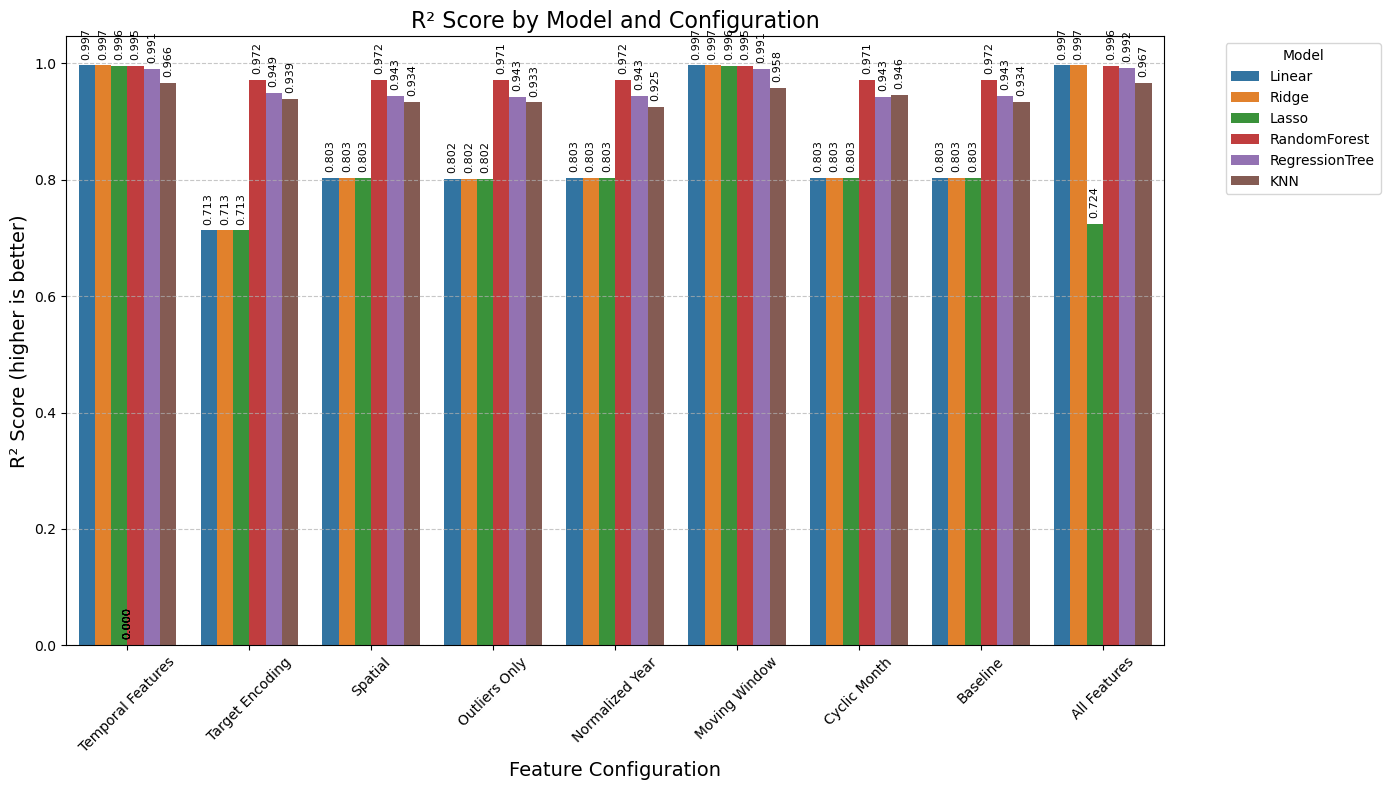


Plotting RMSE comparison...


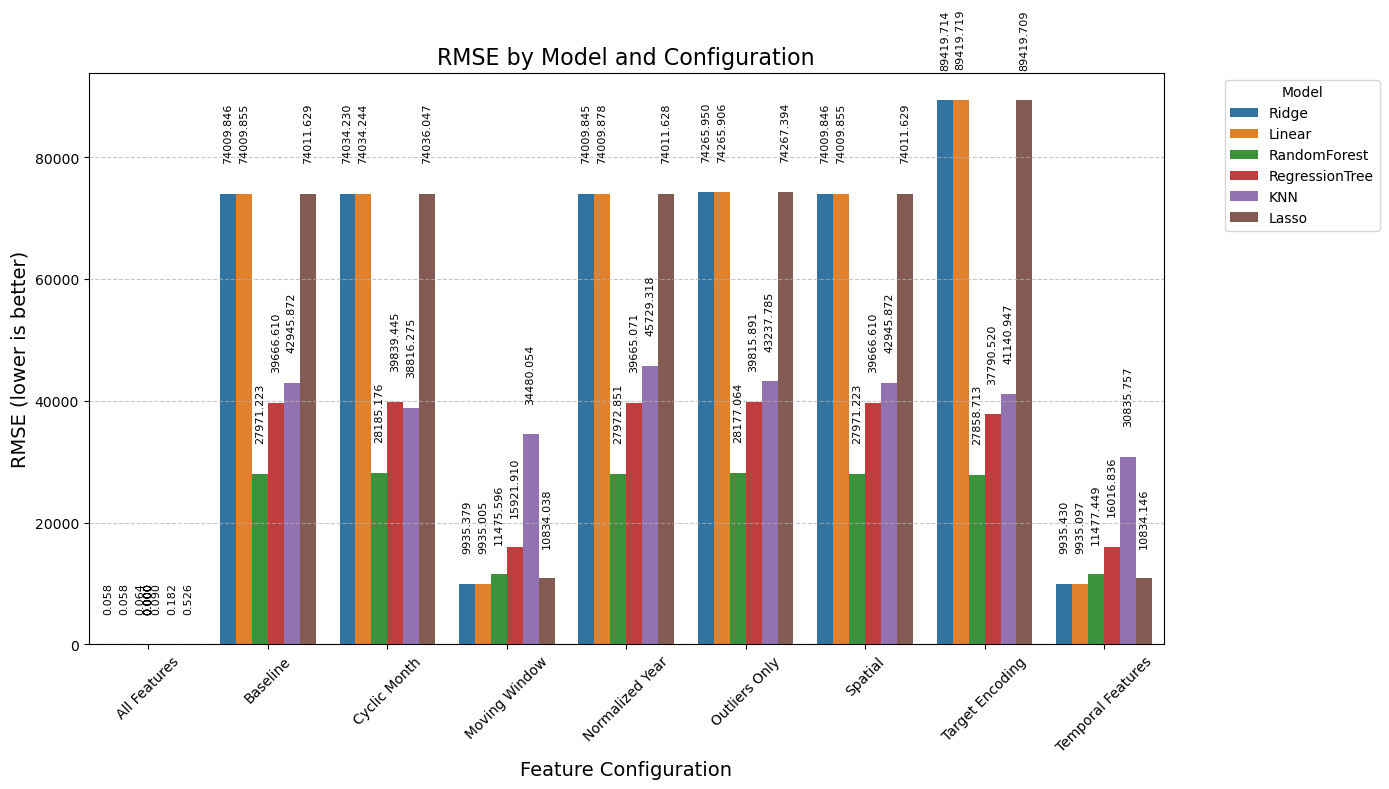


Plotting MAE comparison...


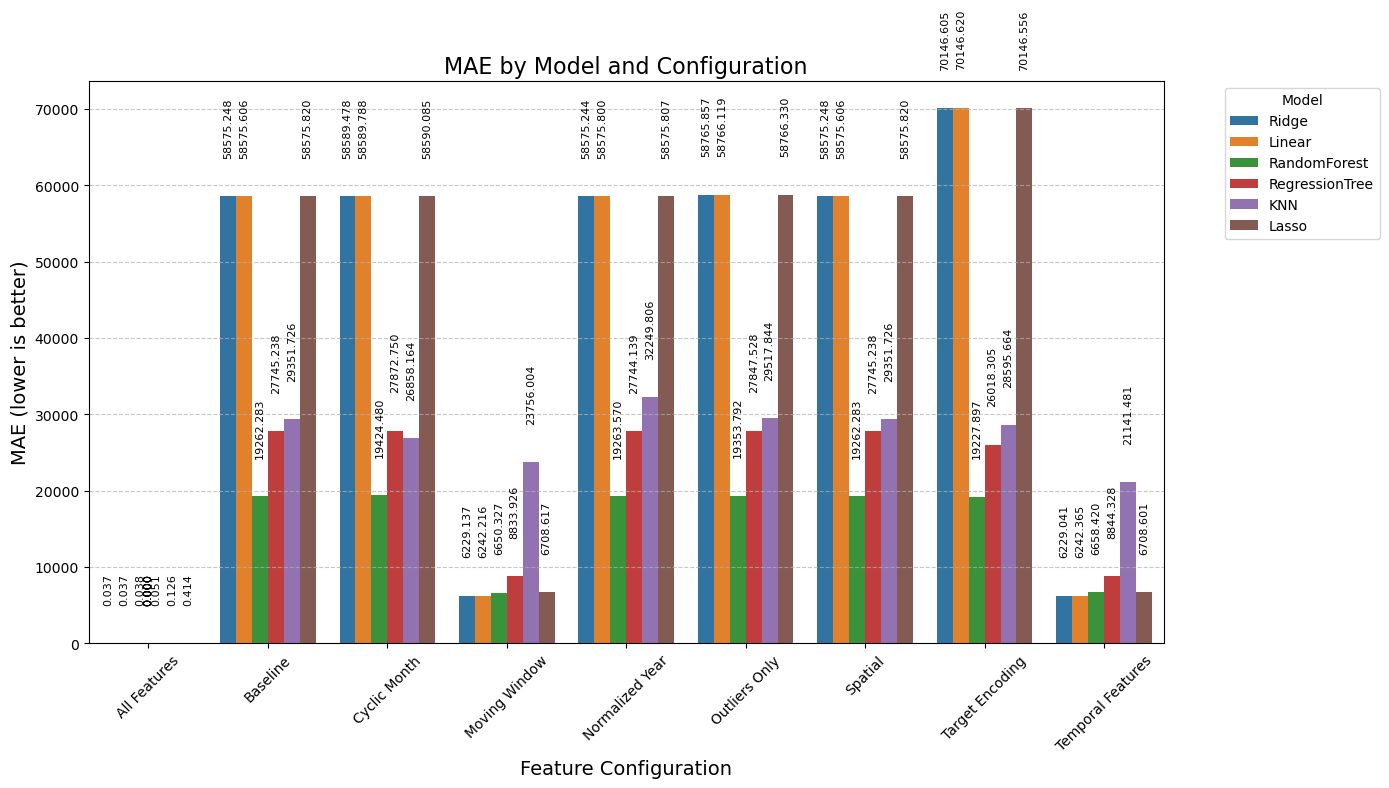


Best Models by Configuration (sorted by R²):
       Configuration    Best Model        R²          RMSE           MAE
8       All Features         Ridge  0.996646      0.057965      0.036852
5      Moving Window        Linear  0.996509   9935.005368   6242.215613
7  Temporal Features        Linear  0.996509   9935.097356   6242.364904
6    Target Encoding  RandomForest  0.972127  27858.712686  19227.896815
0           Baseline  RandomForest  0.971901  27971.222707  19262.283446
1            Spatial  RandomForest  0.971901  27971.222707  19262.283446
4    Normalized Year  RandomForest  0.971898  27972.850774  19263.569737
2      Outliers Only  RandomForest  0.971486  28177.064194  19353.791994
3       Cyclic Month  RandomForest  0.971469  28185.176358  19424.480448

Overall best performance: All Features with Ridge
R²: 0.9966, RMSE: 0.06, MAE: 0.04


In [10]:

# Run the model comparison
print("Starting model comparison across different feature configurations...")
results = run_model_comparison(feature_configs)

# Plot R² comparison
print("\nPlotting R² comparison...")
plot_model_comparison(results, metric='r2')

# Plot RMSE comparison
print("\nPlotting RMSE comparison...")
plot_model_comparison(results, metric='rmse')

# Plot MAE comparison
print("\nPlotting MAE comparison...")
plot_model_comparison(results, metric='mae')

# Summarize the best models
best_models = summarize_best_models(results)
print("\nBest Models by Configuration (sorted by R²):")
print(best_models)

# Find overall best configuration
best_config = best_models.iloc[0]
print(f"\nOverall best performance: {best_config['Configuration']} with {best_config['Best Model']}")
print(f"R²: {best_config['R²']:.4f}, RMSE: {best_config['RMSE']:.2f}, MAE: {best_config['MAE']:.2f}")